In [12]:
%load_ext autoreload
import os
import numpy as np 
import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import project_pca, calculate_Q_metrics

from warnings import simplefilter
simplefilter('ignore')

%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def classify_enterotypes(X):
    c_s = ['g__Bacteroides', 'g__Prevotella', 'g__Ruminococcus']

    y = -np.ones((X.shape[0]))
    
    ent_1_mask_bact = (X['g__Bacteroides'] > 0.2 ) * (X['g__Prevotella'] < 0.05 ) * (X['g__Ruminococcus'] < 0.015 )
    ent_2_mask_bact = (X['g__Bacteroides'] <= 0.2 ) * (X['g__Prevotella'] > 0.05 ) * (X['g__Ruminococcus'] < 0.020 )    
    ent_3_mask_bact = (X['g__Bacteroides'] < 0.2 ) * (X['g__Prevotella'] < 0.05 ) * (X['g__Ruminococcus'] < 0.07 )    
    
    y[ent_1_mask_bact] = 0
    y[ent_2_mask_bact] = 1    
    y[ent_3_mask_bact] = 2    
    
    return y

# Load and preprocess data

In [14]:
# # load AGP-HMP data
# !wget https://figshare.com/ndownloader/files/33927092 -O ./data.zip
# !unzip ./data.zip 

In [4]:
# # Load data from Arumugam et al. 2011
# !wget http://www.bork.embl.de/Docu/Arumugam_et_al_2011/data/tables/MetaHIT_41SangerSamples.genus.txt -O ./data/MetaHIT_41SangerSamples_genus.txt
# !wget http://www.bork.embl.de/Docu/Arumugam_et_al_2011/data/tables/MetaHIT_85IlluminaSamples.genus.txt -O ./data/MetaHIT_85IlluminaSamples_genus.txt
# !wget http://www.bork.embl.de/Docu/Arumugam_et_al_2011/data/tables/Turnbaugh_154Pyroseq16S.genus.txt -O ./data/Turnbaugh_154Pyroseq16S_genus.txt
# !wget https://enterotype.embl.de/MetaHIT_SangerSamples.genus.txt -O ./data/MetaHIT_33SangerSamples_genus.txt

In [15]:
# data_orig = {}
# y_orig = {}

# for dataset_name in tqdm(['AGP', 'HMP']):
#     for tax in ['o', 'f', 'g']: 
#         dataframe = pd.read_csv(f'./data/{dataset_name}/pivot_{tax}_normalized.csv', sep=';')
#         label = f'{dataset_name}_{tax}'
#         data_orig[label] = dataframe.drop('Unnamed: 0', axis=1)


# processed_root = 'data_processed'
# pca_root = './results/pca'

In [24]:
data_orig = {}

df_Sanger = pd.read_table('./data/MetaHIT_33SangerSamples_genus.txt').T
df_Sanger.columns = df_Sanger.iloc[0]
df_Sanger.drop('Unnamed: 0', inplace=True)

# df_Sanger = pd.read_table('./data/MetaHIT_41SangerSamples_genus.txt').T
df_Illumina = pd.read_table('./data/MetaHIT_85IlluminaSamples_genus.txt').T
df_Pyroseq = pd.read_table('./data/Turnbaugh_154Pyroseq16S_genus.txt').T

data_orig['Sanger_g'] = df_Sanger.astype(np.float64)
data_orig['Illumina_g'] = df_Illumina.astype(np.float64)
data_orig['Pyroseq_g'] = df_Pyroseq.astype(np.float64)

processed_root = 'data_processed'
pca_root = './results/pca'

In [25]:
for k,v in data_orig.items():
    print(k,v.shape)

Sanger_g (33, 249)
Illumina_g (85, 483)
Pyroseq_g (154, 165)


In [26]:
# df_Sanger_labels = {'AM-F10-T1':3, 
#                     'AM-F10-T2':3, 
#                     'DA-AD-1':1, 
#                     'DA-AD-2':3, 
#                     'DA-AD-3':3, 
#                     'DA-AD-4':1,
#                    'ES-AD-1':2, 
#                    'ES-AD-2':1, 
#                    'ES-AD-3':1,
#                    'ES-AD-4':3,
#                    'FR-AD-1':3,
#                    'FR-AD-2':3,
#                    'FR-AD-3':2,
#                    'FR-AD-4':3,
#                     'FR-AD-5':3,
#                     'FR-AD-6':1,
#                     'FR-AD-7':3,
#                     'FR-AD-8':3,
#                    'IT-AD-1':3,
#                     'IT-AD-2':3,
#                     'IT-AD-3':3,
#                     'IT-AD-4':1,
#                     'IT-AD-5':3,
#                     'IT-AD-6':3,
#                    'JP-AD-1':2,
#                     'JP-AD-2':3,
#                     'JP-AD-3':3,
#                     'JP-AD-4':2,
#                     'JP-AD-5':3,
#                     'JP-AD-6':2,
#                    'JP-AD-7':2,
#                     'JP-AD-8':2,
#                     'JP-AD-9':2}

# Sanger_y = list(df_Sanger_labels.values())

In [27]:
# # uncomment to use synthetic data

# data_orig = {}
# for path in glob.glob('data/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1]
#     data_orig[label] = dataframe.drop('target', axis=1)

# processed_root = 'data_processed/synthetic'
# pca_root = './results/pca/synthetic'


# Preprocessing

In [30]:
def index_to_mask(index, N_orig):
    
    mask = np.zeros((N_orig))
    
    for i in index:
        mask[i] = 1
    return mask.astype(bool)


# requirement that OTU shound be present at least in RARITY_THRESHOLD percentage of population
RARITY_THRESHOLD = 0.01 
# requirement that OTU variance among population 
STD_THRESHOLD = 1e-3
PATHOLOGICAL_ABUNDANCE_THRESHOLD = None #0.7 

if PATHOLOGICAL_ABUNDANCE_THRESHOLD is not None:
    DATA_SPECIFICATION = f'_pat{PATHOLOGICAL_ABUNDANCE_THRESHOLD}'

else:
    DATA_SPECIFICATION = ''
    
processed_root = 'data_processed' + DATA_SPECIFICATION
os.makedirs(processed_root, exist_ok=True)

preprocessed_data = {}
preprocessing_mask = {}
y_orig = {}

for label, df in data_orig.items():
            
    df_proc = df.copy()
    df_proc.drop_duplicates(inplace=True)
    N = df_proc.shape[0]
    
    # too rare
    rare_otu_mask = (df_proc > 0).sum(0) / N < RARITY_THRESHOLD
    
    # too low std
    std_otu_mask = df_proc.std(0) < STD_THRESHOLD
    
    mask = rare_otu_mask + std_otu_mask
    df_proc = df_proc.iloc[:,~mask.values]
    
    if PATHOLOGICAL_ABUNDANCE_THRESHOLD is not None:
        path_abundance_mask = df_proc.max(1) < PATHOLOGICAL_ABUNDANCE_THRESHOLD
        df_proc = df_proc[path_abundance_mask]
    
    preprocessed_data[label] = df_proc
#     preprocessing_mask[label] = index_to_mask(df_proc.index, df.shape[0])
    
    path = os.path.join(processed_root, f'{label}.csv')
    df_proc.to_csv(path)
    
    n0 = df.shape[0]
    n1 = df_proc.shape[0]
    
    print(f'{label} Data preserved: {n1/n0}')
    print(f'{label} Orig shape: {df.shape}, processed shape: {df_proc.shape}')
    
#     print(f'{label} Orig shape: {df.shape}, processed shape: {df_proc.shape}, mask sum: {preprocessing_mask[label].sum()}')
    
    dataset_name, tax = label.split('_')
#     if tax == 'g':
#         y_orig[dataset_name] = classify_enterotypes(df_proc)
# np.save('enterotypes_clf', y_orig)
# np.save('preprocessing_mask', preprocessing_mask)

Sanger_g Data preserved: 1.0
Sanger_g Orig shape: (33, 249), processed shape: (33, 34)
Illumina_g Data preserved: 1.0
Illumina_g Orig shape: (85, 483), processed shape: (85, 27)
Pyroseq_g Data preserved: 1.0
Pyroseq_g Orig shape: (154, 165), processed shape: (154, 58)


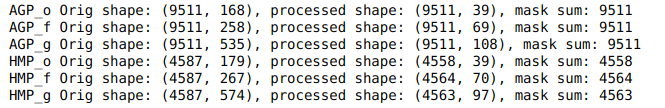

In [14]:
ls -la ./results/pca/synthetic

total 46868
drwxr-xr-x 2 ibulygin users    4096 апр 29 18:10 ./
drwxr-xr-x 3 ibulygin users    4096 апр 29 18:04 ../
-rw-r--r-- 1 ibulygin users 7956441 апр 29 18:10 clust2_dim108
-rw-r--r-- 1 ibulygin users 2907119 апр 29 18:10 clust2_dim39
-rw-r--r-- 1 ibulygin users 5202113 апр 29 18:10 clust2_dim70
-rw-r--r-- 1 ibulygin users 7880683 апр 29 18:10 clust3_dim108
-rw-r--r-- 1 ibulygin users 2907993 апр 29 18:10 clust3_dim39
-rw-r--r-- 1 ibulygin users 5202942 апр 29 18:10 clust3_dim70
-rw-r--r-- 1 ibulygin users 7880644 апр 29 18:10 clust4_dim108
-rw-r--r-- 1 ibulygin users 2908135 апр 29 18:10 clust4_dim39
-rw-r--r-- 1 ibulygin users 5125902 апр 29 18:10 clust4_dim70


# PCA

In [31]:
SAVE=False
os.makedirs(pca_root, exist_ok=True)

data_pca = {}
pca_models = {}

for label, df in preprocessed_data.items():
    
#     if 'AGP' in label or 'HMP' in label:
#         continue
    
    data_projected, pca, pca_proj, mae = project_pca(df, whiten=False)
       
    d_pca = data_projected.shape[1]
    d = df.shape[1]
    
#     Q_loc, Q_glob = calculate_Q_metrics(df.values, data_projected)
    print(f'For {label}, dim orig: {d}, dim PCA: {d_pca}, mae: {np.round(mae,3)}')

#     print(f'For {label}, dim orig: {d}, dim PCA: {d_pca}, mae: {np.round(mae,3)}, Q_loc: {np.round(Q_loc,3)}, Q_glob: {np.round(Q_glob,3)}')
    
    data_pca[label] = data_projected
    pca_models[label] = pca
    
    if SAVE:
        path = os.path.join(pca_root, f'{label}')
        np.savetxt(path, data_projected, delimiter = ';')

For Sanger_g, dim orig: 34, dim PCA: 13, mae: 0.141
For Illumina_g, dim orig: 27, dim PCA: 11, mae: 0.136
For Pyroseq_g, dim orig: 58, dim PCA: 20, mae: 0.141


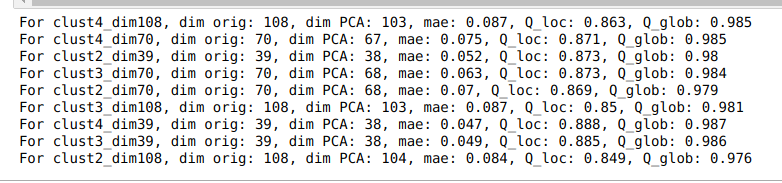

In [19]:
label

'clust2_dim108'

In [22]:
# ##### 
# # color_dict = {'AGP':'red', 'HMP':'green'}
# # linestyle_dict = {'o':'solid', 'f':'dashed', 'g':'dotted'}

# plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})
# plt.figure(figsize=(7,5), dpi=300)
# plt.title(f"Cumulative explained variance", fontsize=20)
# plt.xlabel("Number of PCs", fontsize=20)

# plt.grid(linestyle="dotted")

# cols = {}
# scores = {}

# for label,pca in pca_models.items():
    
#     ev = np.cumsum(pca.explained_variance_ratio_)
    
    
#     plt.plot(ev, 
#              linewidth=3, 
# #              label=label_neat,
#              alpha=0.6,
# #              color=color_dict[dataset_name],
# #              linestyle=linestyle_dict[tax_name]
#             )  

    
# plt.hlines(0.99,0,100,linestyle='--', label='0.99 threshold')

# plt.xscale('log')
# plt.ylim(0.4, 1.)
# plt.legend(fontsize=15)    
# plt.show()

In [ ]:
# ##### color_dict = {'AGP':'red', 'HMP':'green'}
# linestyle_dict = {'o':'solid', 'f':'dashed', 'g':'dotted'}

# plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})
# plt.figure(figsize=(7,5), dpi=300)
# plt.title(f"Cumulative explained variance", fontsize=20)
# plt.xlabel("Number of PCs", fontsize=20)

# plt.grid(linestyle="dotted")

# cols = {}
# scores = {}

# for label,pca in pca_models.items():
    
#     if not label.split('_')[0] in color_dict:
#         continue
    
#     ev = np.cumsum(pca.explained_variance_ratio_)
    
#     dataset_name, tax_name = label.split('_')
    
#     label_neat = dataset_name + f', tax: {tax_name.capitalize()}'
    
#     plt.plot(ev, 
#              linewidth=3, 
#              label=label_neat,
#              alpha=0.6,
#              color=color_dict[dataset_name],
#              linestyle=linestyle_dict[tax_name]
#             )  
    
#     loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
#     loadings_scores = np.linalg.norm(loadings, axis=1)
    
#     cols[label] = [c.split('__')[1] for c in preprocessed_data[label].columns]
#     scores[label] = loadings_scores
    
#     try:
#         aux_ind = cols[label].index('')
#         cols[label].pop(aux_ind)
#         scores[label] = np.delete(scores[label], aux_ind)
#     except:
#         pass
    
# plt.hlines(0.99,0,100,linestyle='--', label='0.99 threshold')

# plt.xscale('log')
# plt.ylim(0.4, 1.)
# plt.legend(fontsize=15)    
# plt.show()

In [40]:
# nshow = 10

# sorted_cols = {}

# fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10), sharey=False, dpi=300)

# for i,dataset_name in enumerate(['AGP', 'HMP']):
#     for j,tax in enumerate(['o', 'f', 'g']): 

#         label = '_'.join([dataset_name, tax])
#         score_label = scores[label]

#         scores_argsort = score_label.argsort()[::-1]

#         scores_sorted = score_label[scores_argsort]
#         labels_sorted = np.array(cols[label])[scores_argsort]

# #         plt.figure(figsize=(5,10))

#         axes[i,j].barh(labels_sorted[:nshow],
#                 scores_sorted[:nshow],
#                 alpha=0.5, 
#                 color=color_dict[dataset_name]
#                )

#         axes[i,j].set_title(dataset_name + f', tax: {tax.capitalize()}')
# #     plt.xticks(rotation=90)

# plt.tight_layout()
    
# plt.show()

# Small datasets PCA

'' is not in list
'1' is not in list
'' is not in list
'-1' is not in list
'' is not in list
'1' is not in list
'-1' is not in list


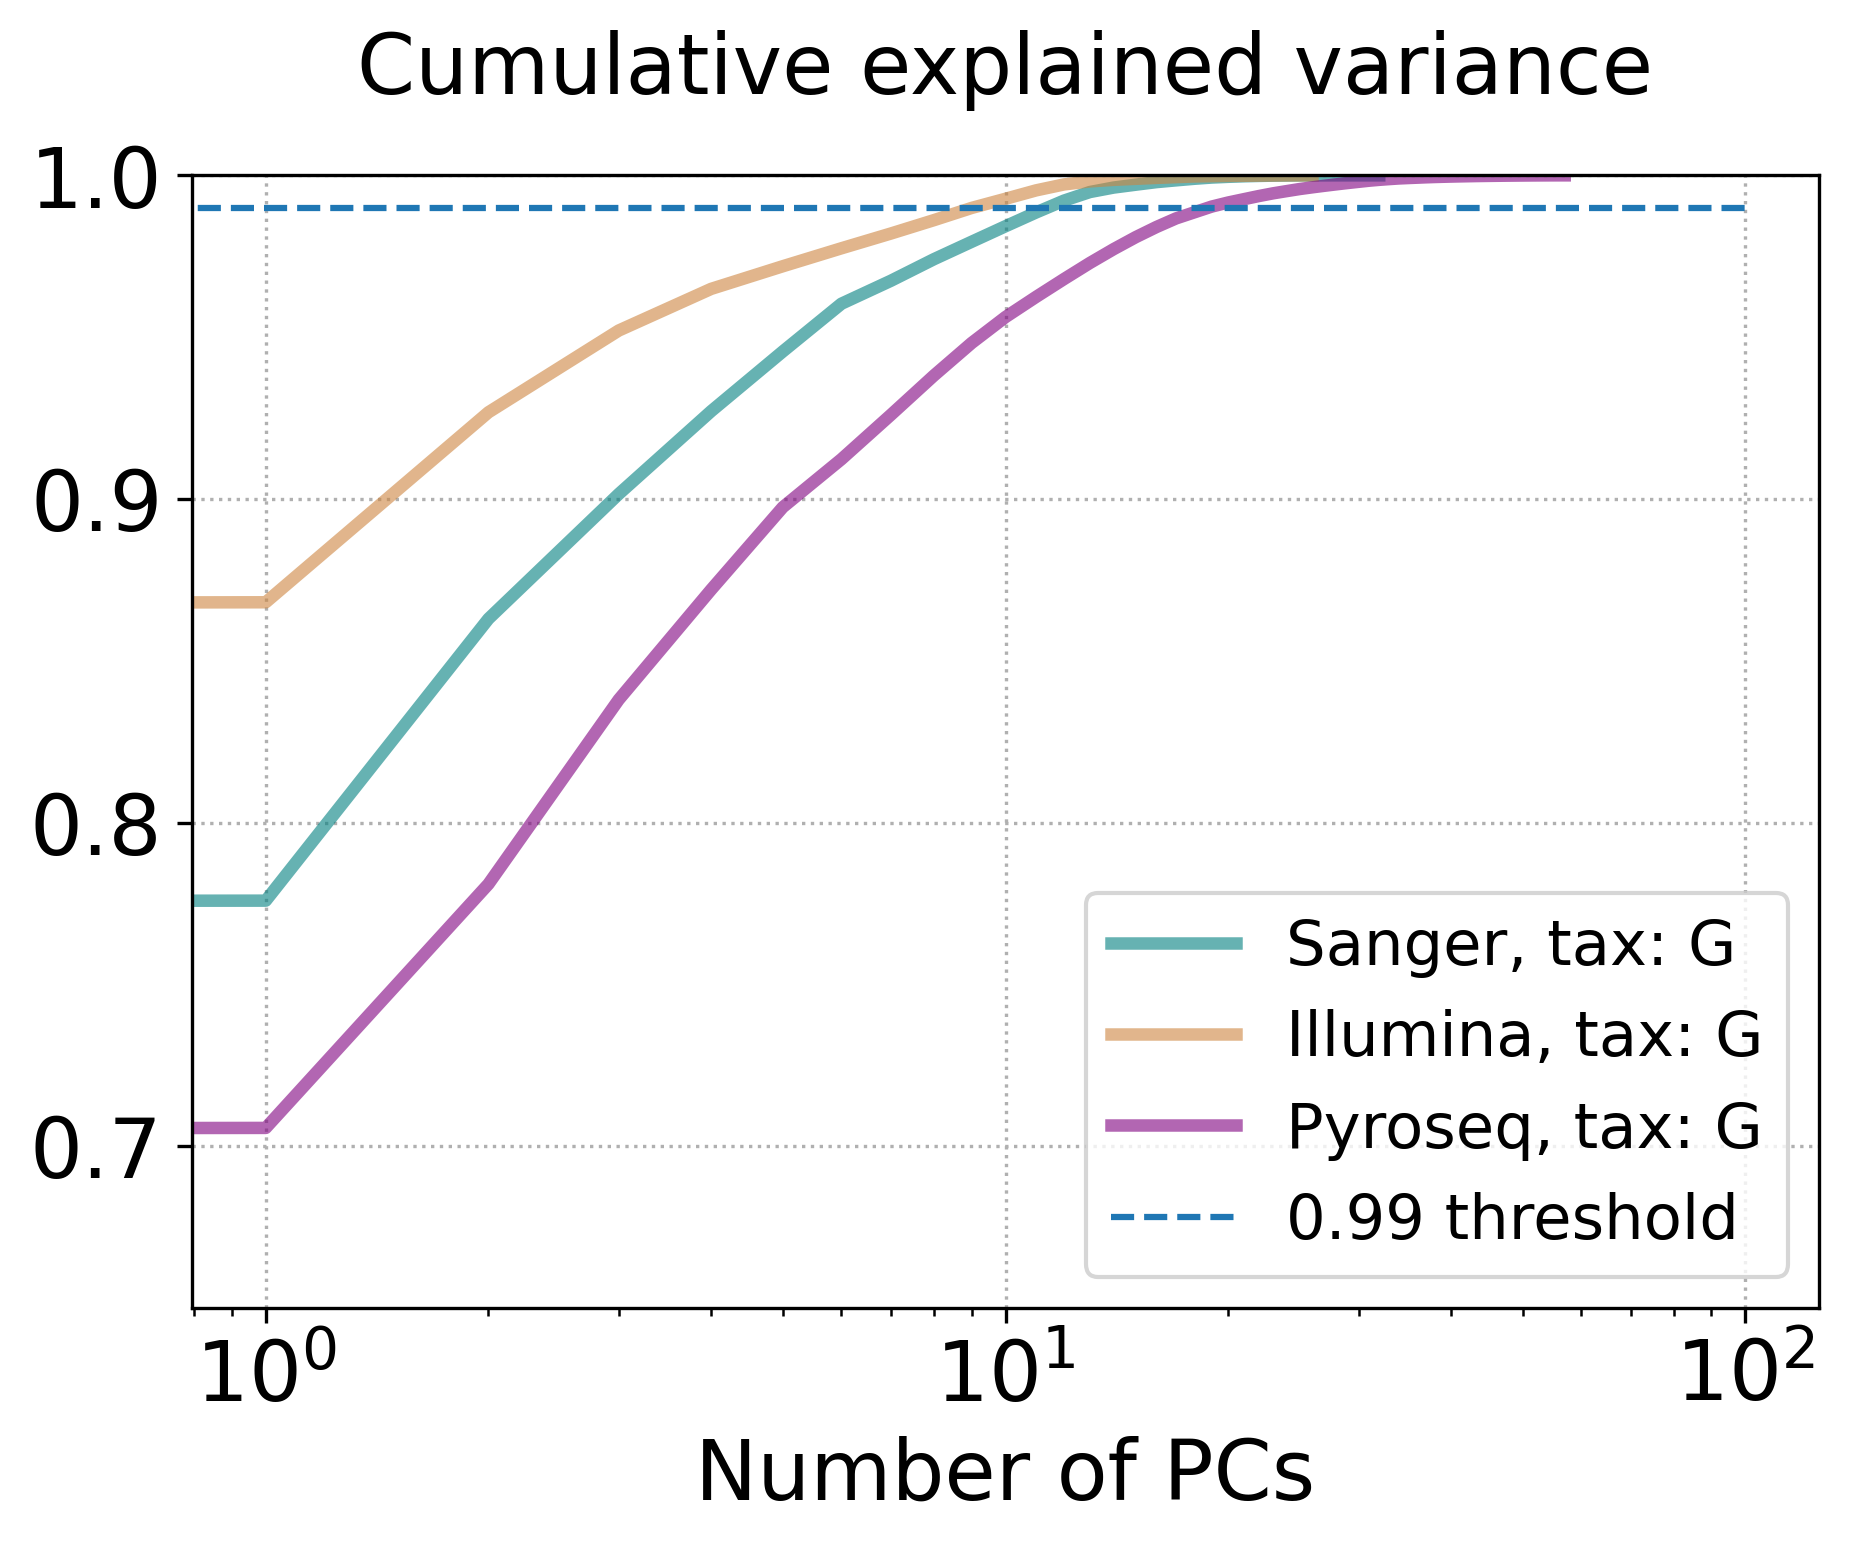

In [44]:
color_dict = {'Sanger':'teal', 'Illumina':'peru', 'Pyroseq':'purple'}

plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})
plt.figure(figsize=(7,5), dpi=300)
plt.title(f"Cumulative explained variance", fontsize=20)
plt.xlabel("Number of PCs", fontsize=20)

plt.grid(linestyle="dotted")

cols = {}
scores = {}

for label,pca in pca_models.items():
    
    if not label.split('_')[0] in color_dict:
        continue
    
    ev = np.cumsum(pca.explained_variance_ratio_)
    
    
    dataset_name, tax_name = label.split('_')
    label_neat = dataset_name + f', tax: {tax_name.capitalize()}'
    
    plt.plot(ev, 
             linewidth=3, 
             label=label_neat,
             alpha=0.6,
             color=color_dict[dataset_name],
             linestyle='solid'
            )  
    
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_scores = np.linalg.norm(loadings, axis=1)
    
    cols[label] = list(preprocessed_data[label].columns)
    scores[label] = loadings_scores
    
    for aux_col in ['', '1', '-1']:
        try:
            aux_ind = cols[label].index(aux_col)
            cols[label].pop(aux_ind)
            scores[label] = np.delete(scores[label], aux_ind)
        except Exception as e:
            print(e)
            continue
            
plt.hlines(0.99,0,100,linestyle='--', label='0.99 threshold')

plt.xscale('log')
plt.ylim(0.65, 1.)
plt.legend(fontsize=15, loc='lower right')    
plt.show()

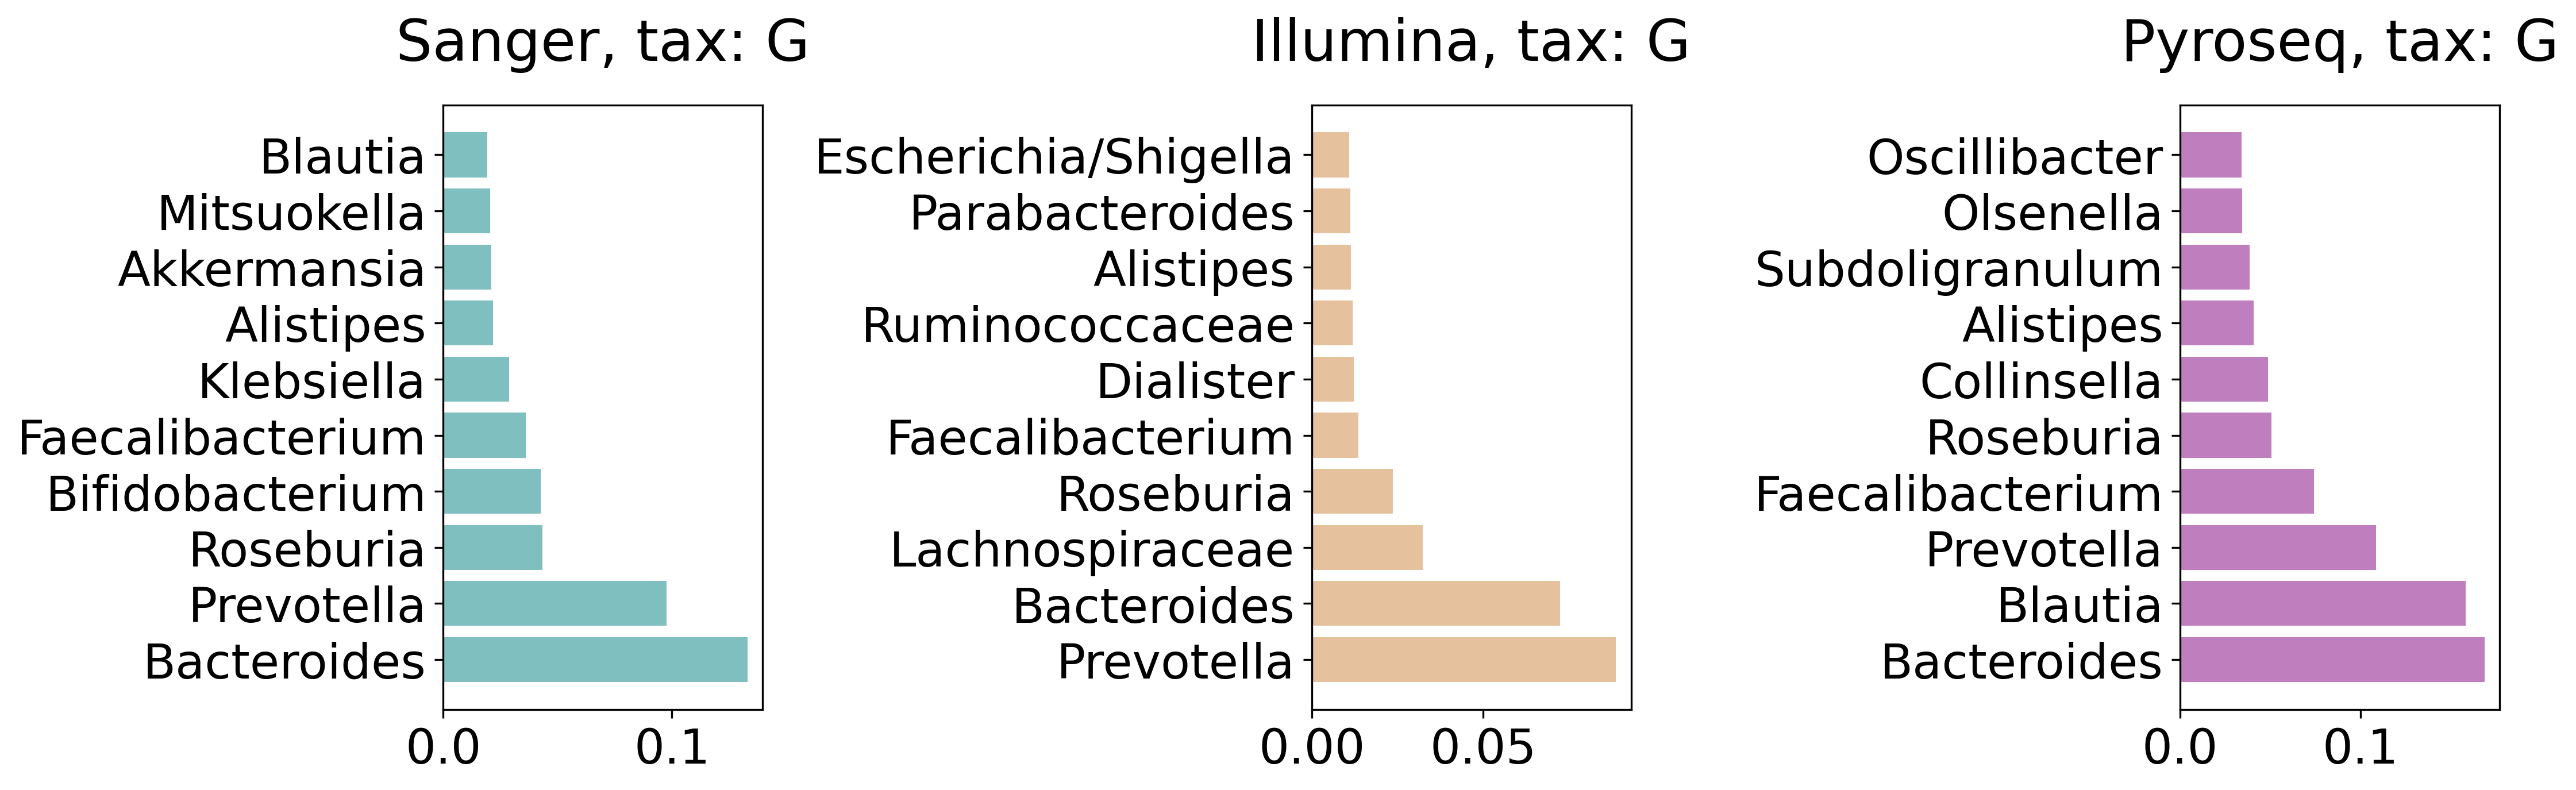

In [45]:
nshow = 10

sorted_cols = {}

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5), dpi=300)
for i,(label, score_label) in enumerate(scores.items()):

    scores_argsort = score_label.argsort()[::-1]
    
    scores_sorted = score_label[scores_argsort]
    labels_sorted = np.array(cols[label])[scores_argsort]

#         plt.figure(figsize=(5,10))
    dataset_name, tax_name = label.split('_')
    axes[i].barh(labels_sorted[:nshow],
            scores_sorted[:nshow],
            alpha=0.5, 
            color=color_dict[dataset_name]
           )

    axes[i].set_title(dataset_name + f', tax: G')
    
#     plt.xticks(rotation=90)

plt.tight_layout()
    
plt.show()

In [184]:
# nshow = 10

# sorted_cols = {}

# fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True)

# for i,tax in enumerate(['o', 'f', 'g']):
#     cols_intersect = np.intersect1d(cols[f'AGP_{tax}'], 
#                                     cols[f'HMP_{tax}'])
#     cols_intersect = np.delete(cols_intersect, np.where(cols_intersect == ''))
    
#     # sort by one of 
    
#     sorted_cols[f'AGP_{tax}'] = [cols[f'AGP_{tax}'][ind] for ind in scores[f'AGP_{tax}'].argsort()[::-1]]
#     sorted_cols[f'HMP_{tax}'] = [cols[f'HMP_{tax}'][ind] for ind in scores[f'HMP_{tax}'].argsort()[::-1]]
    
#     intersect_ind_AGP = [sorted_cols[f'AGP_{tax}'].index(c) for c in cols_intersect]
#     intersect_ind_HMP = [sorted_cols[f'HMP_{tax}'].index(c) for c in cols_intersect] 
    
#     scores_AGP = scores[f'AGP_{tax}'][intersect_ind_AGP]
#     scores_HMP = scores[f'HMP_{tax}'][intersect_ind_HMP]    
    
#     loading_argsort = np.argsort(scores_AGP)[::-1]
#     load_sorted_cols = cols_intersect[loading_argsort]
    
#     axes[i].bar(load_sorted_cols[:nshow],
#             scores_AGP[loading_argsort][:nshow],
#             alpha=0.5, 
#             color='red'
#            )
    
#     axes[i].bar(load_sorted_cols[:nshow],
#             scores_HMP[loading_argsort][:nshow],
#             alpha=0.5,
#             color='green'
#            )
    
#     axes[i].tick_params(labelrotation=45)
    
# plt.show()

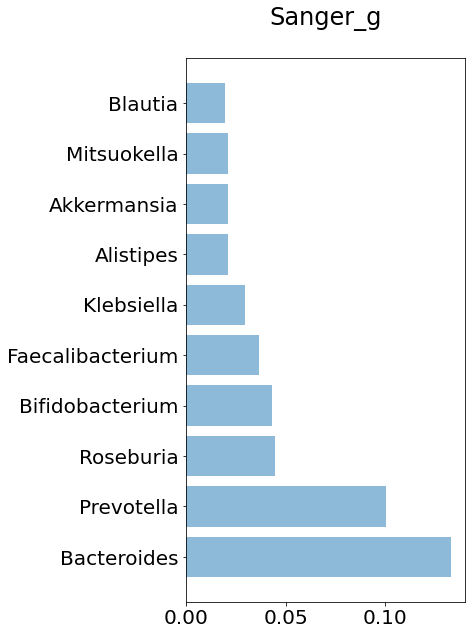

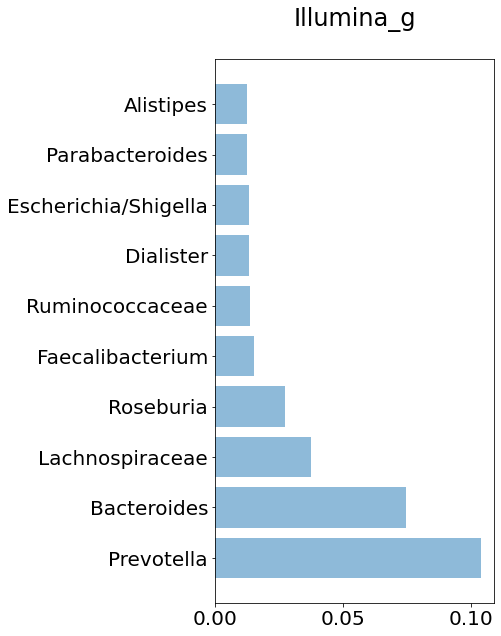

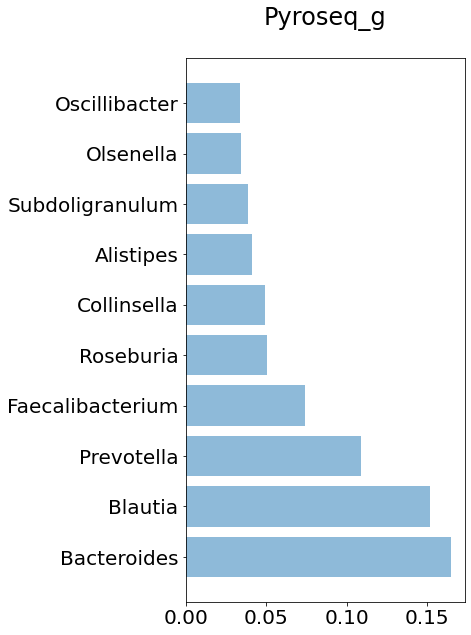

In [185]:
nshow = 10

sorted_cols = {}

# fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,5), sharey=True)

for label, score_label in scores.items():
    
    scores_argsort = score_label.argsort()[::-1]
    
    scores_sorted = score_label[scores_argsort]
    labels_sorted = np.array(cols[label])[scores_argsort]
    
    plt.figure(figsize=(5,10))
    
    plt.barh(labels_sorted[:nshow],
            scores_sorted[:nshow],
            alpha=0.5, 
           )
    
    plt.title(label)
#     plt.xticks(rotation=90)
    
    plt.show()

in both datasets different OTU contribute to the principal components

# Calculate pairwise distances*
*for the faster computation

In [38]:
from scipy.spatial.distance import braycurtis, pdist, squareform, jensenshannon
from joblib import Parallel, delayed

In [39]:
# distance_root = f'distances_processed' + DATA_SPECIFICATION
# os.makedirs(distance_root, exist_ok=True)
# distances_names = ['L1', 'L2', 'JS', 'BC']

In [40]:
# uncomment to use synthetic data

distance_root = 'distances_processed_synth'
os.makedirs(distance_root, exist_ok=True)
# only L1 and L2 distances are supported
distances_names = ['L1', 'L2']

In [52]:
ls -la results/embeddings_params_synthetic

total 8
drwxr-xr-x  2 ibulygin users 4096 янв 27 15:17 ./
drwxr-xr-x 24 ibulygin users 4096 апр 29 16:56 ../


In [41]:
def compute_pdist_l1(data, name, distance_root):
    data_ = data.copy()
    S = squareform(pdist(data_, metric='minkowski', p=1))
    path = os.path.join(distance_root, f'orig_L1_{name}')
    np.save(path, S)
    
# _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l1)(data.drop(['-1', '1'], 
#                                                                                 axis=1, 
#                                                                                 errors='ignore').values, 
#                                                                       name, 
#                                                                       distance_root) 
#                                         for name, data in preprocessed_data.items())

_ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l1)(data.values, 
                                                                      name, 
                                                                      distance_root) 
                                        for name, data in preprocessed_data.items())

In [42]:
def compute_pdist_l2(data, name, distance_root):
    data_ = data.copy()
    S = squareform(pdist(data_, metric='minkowski', p=2))
    path = os.path.join(distance_root, f'orig_L2_{name}')
    np.save(path, S)
    
# _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l2)(data.drop(['-1', '1'], 
#                                                                                 axis=1, 
#                                                                                 errors='ignore').values, 
#                                                                       name, 
#                                                                       distance_root) 
#                                         for name, data in preprocessed_data.items())

_ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_l2)(data.values, 
                                                                      name, 
                                                                      distance_root) 
                                        for name, data in preprocessed_data.items())

In [48]:
intdim = np.load('intrinsic_dims_pca_strict_synthetic.npy', allow_pickle=True).item()

for d in [39,70,108]:
    for k in [2,3,4]:
    
        
        label = f'clust{k}_dim{d}'
        
        print(data_orig[label].shape, data_pca[label].shape, intdim[label])
        
        data_pca

(3000, 39) (3000, 38) 22
(3000, 39) (3000, 38) 21
(3000, 39) (3000, 38) 20
(3000, 70) (3000, 68) 31
(3000, 70) (3000, 68) 29
(3000, 70) (3000, 67) 28
(3000, 108) (3000, 104) 39
(3000, 108) (3000, 103) 37
(3000, 108) (3000, 103) 36


In [37]:
def compute_pdist_js(data, name, distance_root):
    
    data_ = data.copy()
    data_ /= data_.sum(1, keepdims=True)
    
    N = data_.shape[0]
    S = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            d = jensenshannon(data_[i], data_[j])
            S[i,j] = d
            S[j,i] = d
            
    path = os.path.join(distance_root, f'orig_JS_{name}')
    np.save(path, S)
    
if 'JS' in distances_names:
    _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_js)(data.drop(['-1', '1'], 
                                                                                axis=1, 
                                                                                errors='ignore').values,
                                                                          name, 
                                                                          distance_root) 
                                            for name, data in preprocessed_data.items())

In [38]:
def compute_pdist_bc(data, name, distance_root):
    data_ = data.copy()
    N = data_.shape[0]
    data_ /= data_.sum(1, keepdims=True)
    
    S = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            d = braycurtis(data_[i], data_[j])
            S[i,j] = d
            S[j,i] = d
            
    path = os.path.join(distance_root, f'orig_BC_{name}')
    np.save(path, S)
    
if 'BC' in distances_names:
    _ = Parallel(n_jobs=len(preprocessed_data))(delayed(compute_pdist_bc)(data.drop(['-1', '1'], 
                                                                                axis=1, 
                                                                                errors='ignore').values,
                                                                          name,
                                                                          distance_root) 
                                            for name, data in preprocessed_data.items())